# Credit Risk
# Bachelor Thesis - Bocconi University 

## Credit risk modelling: an empirical analysis on Probability of Default (PD) estimation 
solution provided by: **Daniel Travaglia**

## Draft of the outline of the notebook

0. Introduction: frame the problem
1. Prerequisites: set up the environment
2. Retrieve and describe the dataset
3. Discover and visualize data for reacher insights 
4. Data cleaning for modelling (missing values) 
5. Machine Learning Pipelines:
    - Model (1): Logistic Regression Model
        1. Data prepocessing and model definition
        2. Model better evaluation using cross validation and fine-tuning model parameters using grid search
        3. Retrieve the optimal model 
    - Model (2): Ensemble Model (Gradient Boosting)
        1. Data preprocessing and model definition
        2. Model better evaluation using cross validation and fine-tuning model parameters using grid search
        3. Retrieve the optimal model
6. Get the best model (metric comparison)
7. Evaluate the system on the test set and plot the results
8. Conclusions
9. (Bonus) Further improvements

## TODO

2) [TODO -> Today] Explanatory analysis + Give appropriate introduction and description

3) [TODO -> Today/Tomorrow] Calibration of default probability: since we do not have time-series data, we could actually calibrate default probabilities per-group: group by ratings and then by whether the client defaulted or not. At this point, estimate the probability of defaulting (modelling using a Bernoulli RV then) by calculating the proportion of defaulted clients out of the total clients for that specific rating 

4) [TODO -> Tomorrow] -> Provide a high-level overview of the credit risk world, with a particular attention in being able to introduce the topic in an understandable manner!

5) [TODO -> Today] -> injecting interest rates (missings) based on the information provided by ratings (random sampling between min-max of int. rates for a specific ranking) -> replacing missing values

# (0) Introduction: frame the problem

[TODO]: Provide a high-level description of what is credit risk modelling, what characterize it and how this activity is usually done in financial istitutions. Particular attention on PD, EAD and LGD.

# (1) Set up the environment

In this section the core libraries that will be used throughout the entire notebook are loaded. 
* NumPy and Pandas provide the fundamental tools to handle datasets and arrays.
* Skikit-learn provides amazing tools that simplify quite significantly the modelling part.
* Last but not least, matplotlib and seaborn are amazing libraries that enables to create effective visualizations to explore the data even further.

### (0.1) Retrieving libraries

In [1]:
# Data manipulation ML libraries
import numpy as np 
import pandas as pd
from scipy import stats
from scipy.stats import norm

# Ignore irrelevant warnings to make the code nicer!
import warnings
warnings.filterwarnings('ignore')

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 

# database libraries
import pyodbc                       

# graphic settings
# Make things work smoother for plots
%matplotlib inline
# Se the backend of plotting to matplotlib
pd.options.plotting.backend = 'matplotlib'
# Change the style of seaborn graphs
sns.set_style("white")
sns.set_palette("Blues")

### (0.1) Loading data settings

In [2]:
## CSV
# Counterparty data path
cp_path = "data\counterparty.csv"
# Counterparty loans data path
cp_loans_path = "data\counterparty_loans.csv"

In [3]:
## SQL Server

# # Defining connection string
# driver = "{SQL Server}"
# server = "DESKTOP-KI4LIGE" # retrieve this in SQL by typing @@SERVERNAME
# database = "Thesis"
# connection = "yes"
# conn_string = f"Driver={driver};Server={server};Database={database};Trusted_Connection={connection}"

# # Defining connection string
# conn = pyodbc.connect(conn_string)

# # Defining query to extract data from tables
# sql_cp_query = """
#     SELECT * 
#     FROM dbo.Counterparty
# """
# sql_cp_loans_query = """
#     SELECT *
#     FROM dbo.Counterparty_loan
# """

In [4]:
# MongoDB

## Recap

[Little recap of what we have covered in this chapter and why it is relevant in this context]

# (2) Retrieve and describe the dataset

Goal of this section is to provide information on the structure of the dataset used for the analysis. To begin with, a high-level description of the two tables will be given. Later on, by getting out hands dirty with the data, we will take a closer look at the data and conduct a sanity check to see whether the data is consistent and in line with expectations.

## (2.1) Loading the datasets

The data are spread across 2 different tables:

* **Counterparty**: this dataset contains some general characteristics and information regarding the counterparties 
* **Loans**: this dataset is equipped with relevant information on the loans provided by a financial istitution.

Before proceeding, it is important to clarify an relevant characteristic of our data. As we will see later, each counterparty from the "counterparty" table is associated with one (and only one) loan from the "loans" table. This means that there is a one-to-one mapping between counterparties and loans, which is not usually corresponding to a classic scenario within a financial or any other credit lending istitution that wish to model some credit risk metrics. Indeed, the latters make use of time-series data, which often provide a credit history of all the accounts (i.e. each financial instruments that the financial istitution can provide to the client) for multiple periods. In this context, the scenario is completely different: we are dealing with a panel data. In particular, each observation represents a snapshot of the credit availability associated with a counterparty at a certain point in time that is shared among all the observations. In other words, we get rid of the time dimension. Clearly, this translates into two different approaches to estimate probability of default. A financial istitution might want to model the PD ("probability of default") taking into account factors that are time-dependent (e.g. market risk factor, macroeconomic scenarios and so ). Given the nature and the structure of the data however, will force us in keeping things simple with a much less ambitious objective: we would like to estimate the proability that a counteparty default on its obligations by taking into consideration its characteristics and that of the financial obligation.

### (2.1.1) Retrieving data from CSV

In [5]:
# Retrieving counterparty data
df_cp = pd.read_csv(cp_path)
# Retrieving counterparty loans data
df_cp_loans = pd.read_csv(cp_loans_path)

# make sure the file is loaded
assert not (df_cp.empty and df_cp_loans.empty)

### (2.1.2) Retrieving data from SQL server

In [6]:
# # Injecting data into pandas DateFrame
# df_cp = pd.read_sql(sql_cp_query,conn)
# df_cp_loans = pd.read_sql(sql_cp_loans_query,conn)

# # Inspecting whether we have indeed extract something out of the SQL server
# assert not (df_cp.empty or df_cp_loans.empty)

### (2.1.3) Retrieving data from MongoDB server

In [7]:
# MongoDB

## (2.2) A first glence at the data

After loading the dataset, we are ready to get our hands dirty. We will first explore the counterparty table, from its shape to some concrete of examples that are store in it to verify consistency in the data. We will then proceed with the same type of analysis on the loan table and, evenutally, we will merge the two dataset to retrieve additional insights with a combined analysis.

### (2.2.1) Counterparties dataset

In [8]:
df_cp.shape

(32581, 7)

The counterparty dataset contains 32581 observations, each of which represents a specific counterparty. The latters are described is then described by 7 different features. Let's now dig a little bit more to discover what type of information we have on the counterparties

In [9]:
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_cp                       32581 non-null  int64  
 1   cp_age                      32581 non-null  int64  
 2   cp_income                   32581 non-null  int64  
 3   cp_home_ownership           32581 non-null  object 
 4   cp_emp_length               31686 non-null  float64
 5   cp_person_default_on_file   32581 non-null  object 
 6   cp_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 1.7+ MB


The dataset provides the following information regarding the counterparties: 
* Age: age of the person 
* Income: personal income in $ (dollars)
* Home ownership: whether the person owns a house or it is supplied with in other ways (RENT, MORTGAGE, ... or other financial instruments)
* Employment length: how long (in years) the person has been employed
* Person default on file: whether in the past the person has already defaulted or not on an obligation
* Credit history length: length of the credit grant in years up until now

Let's clarify some points that emerge from this simple table

1. It can be easily noticed that some observations for "employment length" variable are missing. This is a situation that must be handled somehow before proceeding into the modelling section

2. We want to turn some variables (e.g. home ownership and person default on file) into categorical features. Such procedure will simplify our analysis quite significantly and it will be specially relevant for the modelling part.

At this point you might wonder: how's the data looks like?

In [10]:
df_cp.head()

,id_cp,cp_age,cp_income,cp_home_ownership,cp_emp_length,cp_person_default_on_file,cp_person_cred_hist_length
0,1,22,59000,RENT,123.0,Y,3
1,2,21,9600,OWN,5.0,N,2
2,3,25,9600,MORTGAGE,1.0,N,3
3,4,23,65500,RENT,4.0,N,2
4,5,24,54400,RENT,8.0,Y,4


It seems that we have relevant information regarding the counterparties. It is worth discussing on the following point before proceeding: 

* Presence of outliers: the first observation is characterized by a value for "employment length" that is clearly out of range: how could a person be employed for 123 years? And how would it be possible for a 22 years old person in the first place?

* The issue highlighted here might have further implications which is probably worth discussing before proceeding: we saw how it is important in a analytical project to have a rough idea of what each variable represents. If combined with a proper explanatory analysis (which will be provided later), it is possible to spot most of the inconsistencies in the data (i.e. bad outliers). However, this might not be enough: the counterparty could provide false information to the creditor to increase the likelihood of obtaining the credit. Such setting is usually worsen by the presence of asymmetric information between the two parties. Indeed, the fact that one party is more informed that the other party might generate some inefficencies in the lending market. This will be topic of discussion for the last chapter of this paper.

Let's explore some statistics to see whether there is presence of other inconsistencies in the data.

In [11]:
df_cp.describe()

,id_cp,cp_age,cp_income,cp_emp_length,cp_person_cred_hist_length
count,32581.000000,32581.000000,3.258100e+04,31686.000000,32581.000000
mean,16291.000000,27.734600,6.607485e+04,4.789686,5.804211
std,9405.468897,6.348078,6.198312e+04,4.142630,4.055001
min,1.000000,20.000000,4.000000e+03,0.000000,2.000000
25%,8146.000000,23.000000,3.850000e+04,2.000000,3.000000
50%,16291.000000,26.000000,5.500000e+04,4.000000,4.000000
75%,24436.000000,30.000000,7.920000e+04,7.000000,8.000000
max,32581.000000,144.000000,6.000000e+06,123.000000,30.000000


From the description above, the issue identified above is even easier to spot: the maximum employment length among all observations is 123 years. Moreover, the maximum registred age for a counterparty is 144 years. Such values will definetely require further investigation and manipulation to obtain a dataset on top of which we can work on. All the other numbers seem to be reasonably acceptable.

### (2.2.2) Loans dataset

Let's now switch to the loans dataset. This table provides information regarding single loans that were provided to a counterparty by means of a financial istitution

In [6]:
df_cp_loans.shape

(32581, 8)

The dataset on loans has the same number of observations as the one on counterparties. This is another confirmation of the presence of a one-to-one matching between counterparties and loans. Each loan is described by 8 different features.

In [13]:
df_cp_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id_loan              32581 non-null  int64  
 1   loan_intent          32581 non-null  object 
 2   loan_grade           32581 non-null  object 
 3   loan_amount          32581 non-null  int64  
 4   loan_int_rate        29465 non-null  float64
 5   loan_status          32581 non-null  int64  
 6   loan_percent_income  32581 non-null  float64
 7   fk_cp                32581 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 2.0+ MB


The following information on loans are provided:

* Loan intent: reason declared by the counterparty to get the loan

* Loan grade: the rating associated with the loan and the relative counterparty. This gives us insights on the risk associated with this loan, and it is usually driven by the loan characteristics, as well as counterparties characteristics

* Loan amount: the amount of the loan

* Loan interest rate: the interest rate associated with the loan.

* Loan status: whether the counterparty has defaulted or not on such loan (1 is defaulted, 0 is not). This is going to be our dependent variable: we want to estimate the probability that a customer is going to default given certain characteristics on the loans (loans dataset) along with characteristics on the counterparty itself (counterparty dataset)

* Loan percent income: the proportion of the loan amount with respect to the income of the relative counterparty 

It seems that a huge amount of observations do not have information on the interest rate applied to the loan. Being an indicator of how risky the investment is, one possibility to get rid of these missing values could be represented by applying a map between ratings and interest rates and replace them based on a random sampling within the range of the interest rate for a specific category (i.e. loan_intent) and for the rating characterizing such loan (i.e. loan_grade). Doing so however, there is the risk of injecting biased information in the data that might lead eventually to have bad predictiory power from the model.

In [14]:
df_cp_loans.head()

,id_loan,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income,fk_cp
0,1,PERSONAL,D,35000,16.02,1,0.59,1
1,2,EDUCATION,B,1000,11.14,0,0.10,2
2,3,MEDICAL,C,5500,12.87,1,0.57,3
3,4,MEDICAL,C,35000,15.23,1,0.53,4
4,5,MEDICAL,C,35000,14.27,1,0.55,5


The first observations do not signal any particular concern on the data. Let's see whether this is also confirmed by the statistics.

In [15]:
df_cp_loans.describe()

,id_loan,loan_amount,loan_int_rate,loan_status,loan_percent_income,fk_cp
count,32581.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,16291.000000,9589.371106,11.011695,0.218164,0.170203,16291.000000
std,9405.468897,6322.086646,3.240459,0.413006,0.106782,9405.468897
min,1.000000,500.000000,5.420000,0.000000,0.000000,1.000000
25%,8146.000000,5000.000000,7.900000,0.000000,0.090000,8146.000000
50%,16291.000000,8000.000000,10.990000,0.000000,0.150000,16291.000000
75%,24436.000000,12200.000000,13.470000,0.000000,0.230000,24436.000000
max,32581.000000,35000.000000,23.220000,1.000000,0.830000,32581.000000


All the numerical features seem reasonably within the expected range. This analysis, as well as the previous ones, should be further supported with some visualizations and statistics to provide richer insights and discover patterns in the data. This will be subject of the next chapter.

### (2.2.3) Merging the datasets

In this section, we will merge the two tables into one wider and comprehensive dataframe. We will then proceed cleaning up the data before moving into visualizations

Here we merge the two datasets and we get rid of variables that are no more of good use

In [7]:
# Inner join between tables
df = pd.merge(df_cp,df_cp_loans,how="inner",left_on="id_cp",right_on="fk_cp")
# make sure everything is working correctly
assert (len(df) == len(df_cp) == len(df_cp_loans)) and (df.shape[1] == df_cp.shape[1] + df_cp_loans.shape[1])
# Drop useless variables
df.drop(columns=['id_cp','fk_cp','id_loan'],inplace=True)

Removing inconsistencies in the data related to age and employment length that we spotted previously

In [9]:
# Clean the dataset 

# Drop outliers
# Retrieve the number of values which are not reasonable
df_invalid = df[(df.cp_age > 100) | (df.cp_emp_length > 50)]
# Dropping absurd values from the dataset
df.drop(index=df_invalid.index,inplace=True)

Let's also dig into the missing values

In [10]:
df.isnull().sum().sort_values(ascending=False)

loan_int_rate                 3115
cp_emp_length                  895
loan_percent_income              0
loan_status                      0
loan_amount                      0
loan_grade                       0
loan_intent                      0
cp_person_cred_hist_length       0
cp_person_default_on_file        0
cp_home_ownership                0
cp_income                        0
cp_age                           0
dtype: int64

In [13]:
# Drop missing values
df.dropna(inplace=True)

In [14]:
# mapping defaulted on file into 0-1 variables
mapping_defaulted = {
    "Y":1,
    "N":0
}
# modify the dataframe to respect this convention
df.loc[:,'cp_person_default_on_file'] = df.cp_person_default_on_file.map(mapping_defaulted)

# assert 
assert not np.any((df.cp_person_default_on_file == "N") & (df.cp_person_default_on_file == "Y"))

As a last step, let's turn the non-numeric variables into categorical.

In [15]:
# Get categorical variables
for col in ('cp_home_ownership','cp_person_default_on_file','loan_intent','loan_grade','loan_status'):
    df[col] = pd.Categorical(df[col])

# check 
df.dtypes

cp_age                           int64
cp_income                        int64
cp_home_ownership             category
cp_emp_length                  float64
cp_person_default_on_file     category
cp_person_cred_hist_length       int64
loan_intent                   category
loan_grade                    category
loan_amount                      int64
loan_int_rate                  float64
loan_status                   category
loan_percent_income            float64
dtype: object

In [16]:
df.head()

,cp_age,cp_income,cp_home_ownership,cp_emp_length,cp_person_default_on_file,cp_person_cred_hist_length,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income
1,21,9600,OWN,5.0,0,2,EDUCATION,B,1000,11.14,0,0.10
2,25,9600,MORTGAGE,1.0,0,3,MEDICAL,C,5500,12.87,1,0.57
3,23,65500,RENT,4.0,0,2,MEDICAL,C,35000,15.23,1,0.53
4,24,54400,RENT,8.0,1,4,MEDICAL,C,35000,14.27,1,0.55
5,21,9900,OWN,2.0,0,2,VENTURE,A,2500,7.14,1,0.25


[TODO] After some cleaning, it seems that the numbers now are reasonably in range. We are then  proceed with some visualization techniques to enrich our analysis and see whether we can find hidden patterns in the data

# (3) Data exploration and visualization for richer insights

In [18]:
df_analysis.describe()

NameError: name 'df_analysis' is not defined

In [60]:
df_analysis = df.dropna()

In [64]:
# Description of the dataset
df_analysis.head()

,cp_age,cp_income,cp_home_ownership,cp_emp_length,cp_person_default_on_file,cp_person_cred_hist_length,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_status,loan_percent_income
1,21,9600,OWN,5.0,0,2,EDUCATION,B,1000,11.14,0,0.10
2,25,9600,MORTGAGE,1.0,0,3,MEDICAL,C,5500,12.87,1,0.57
3,23,65500,RENT,4.0,0,2,MEDICAL,C,35000,15.23,1,0.53
4,24,54400,RENT,8.0,1,4,MEDICAL,C,35000,14.27,1,0.55
5,21,9900,OWN,2.0,0,2,VENTURE,A,2500,7.14,1,0.25


In [65]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28632 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   cp_age                      28632 non-null  int64   
 1   cp_income                   28632 non-null  int64   
 2   cp_home_ownership           28632 non-null  category
 3   cp_emp_length               28632 non-null  float64 
 4   cp_person_default_on_file   28632 non-null  category
 5   cp_person_cred_hist_length  28632 non-null  int64   
 6   loan_intent                 28632 non-null  category
 7   loan_grade                  28632 non-null  category
 8   loan_amount                 28632 non-null  int64   
 9   loan_int_rate               28632 non-null  float64 
 10  loan_status                 28632 non-null  category
 11  loan_percent_income         28632 non-null  float64 
dtypes: category(5), float64(3), int64(4)
memory usage: 1.9 MB


Let's first get a first sense of how does the data looks like before proceeding. We can notice that we have a mixture of numerical and categorical data to visualize and to further analyze. 

### Plotting

In [73]:
# Define function for plotting
def sns_plot(*plot_args):

    # Retrieve graph options
    plot_dict = plot_args[0]
    plot_options = plot_dict["plot_options"]

    # if plot_options["type"] == "univ":
    #     # Get the data
    #     df_plot = plot_dict["df"]
    #     # Get the dimension for subplot

    # Settings
    plt.figure(figsize=(12,7))
    df_plot = plot_dict["df"]
    x = plot_dict["x"]
    y = plot_dict["y"]

    # Differentiate between graphs

    if plot_options["kind"] == "bar":
        g = sns.barplot(x=x, y=y, data=df_plot,palette=plot_options["palette"])
    elif plot_options["kind"] == "count":
        g = sns.countplot(x=x,hue=plot_options["hue"],palette=plot_options["palette"],order=plot_options["order"])
        g.legend(loc="upper left")
    elif plot_options["kind"] == "boxplot":
        g = sns.boxplot(data=df_plot,x=x,y=y)
    elif plot_options["kind"] == "violin":
        g = sns.violinplot(data=df_plot, x=x, y=y, hue=plot_options["hue"],inner="quart",split=True)
    # elif plot_options["kind"] == "pairplot":
    #     g = sns.pairplot(data=df_plot,size=2.5)
    elif plot_options["kind"] == "scatter":
        g = sns.scatterplot(x=x.x,y=y,data=df_plot,s=40,color="m")
    else:
        raise Exception("Not a valid graph option")

    # Options shared for each graph
    for p in g.patches:
        g.annotate(int(p.get_height()), (p.get_x() + p.get_width()/2, p.get_height()), ha='center', va='center', xytext=(0,10), textcoords = 'offset points')
    g.set_title(plot_options["title"],fontsize=20,fontweight="bold")
    g.set_xlabel(plot_options["x_label"],fontsize=16)
    g.set_ylabel(plot_options["y_label"],fontsize=16)
    # g.legend(loc="upper left")

    # if plot_dict["kind"] not in ("bar,count,pie"):
    #     print("Not what we would like to have here")
    # elif kind == "bar":
    #     g = sns_

# TRIAL 1
# grade_df = df_cp_loans.groupby(['loan_grade'])['loan_int_rate'].mean().sort_values(ascending=True).reset_index()

# plot_args = {
#     "df": grade_df,
#     "x": "loan_grade",
#     "y": "loan_int_rate", 
#     "plot_options": {
#         "kind": "bar",
#         "title": "Average interest rate per rating",
#         "x_label": "Rating",
#         "y_label": "Interest rate",
#         "palette":"Blues"
#     }
# }

# plot_args = {
#     "df": df,
#     "x": "loan_grade",
#     "y": "loan_int_rate", 
#     "plot_options": {
#         "kind": "violin",
#         "hue": "loan_status",
#         "title": "Distribution of loan amount per rating in case of default or not",
#         "x_label": "Rating",
#         "y_label": "Interest rate",
#         "palette": {1: "Defaulted", 0: "Not defaulted"}
#     }
# }

# sns_plot(plot_args)  

## TRIAL 1
# grade_df = df_cp_loans.groupby(['loan_grade'])['loan_int_rate'].mean().plot(kind='bar')
# plot_args = {
#     "kind": "bar",
#     "title": "Average interest rate per rating",
#     "x_label": "Rating",
#     "y_label": "Interest rate"
# }


In [43]:
#df_cp_loans.

In [44]:
# df_cp_loans.groupby(['loan_grade','loan_status'])['loan_status'].count().plot(kind='bar')

# Here new stuff to merge!

In order to better understand the data we are working with we will carefully analyze each single variable closely to try to understand its meaning and relevance for the problem at hand. If properly handle, this process can ease our analysis and provide with additional information and insights before proceeding into modelling. Preparing a table/dataframe with the following attributes for each of the remaining variable would turn out to be of extremely good use:

* **Variable**: name of the variable
* **Type**: either "categorical" (factor) or numerical (number)
* **Segment**: we could categorize the variable into "n" segments: 

    * Counterparty: variables that give information regarding counterparties 
    * Loans: information on the loan issued to a counterparty
    * Default: either inform on the chance of default a loan has, or whether the counterparty has already defaulted in the past
    
* **Expectation**: our expectation of the influence of this variable on the dependent variable (e.g. either "High","Medium","Low" impact)
* **Conclusion**: our conclusion after taking a look at the data (using same scale as "Expectation" for comparison purposes)
* **Comment**: comment on the result, with a particular focus on describing the difference between expectation and conclusion

This process will help us in setting up what in a statistical setting, and to be more precise, in a Bayesian context a person would call "prior information": we expect that some variables will have a higher impact on the variable that we are trying to model (what we defined "expectation"). The aim of the analysis then is to update such belief and retrieve the "posterior information", or in other words, the updated prior (what we defined "conclusion"). Why is this procedure relevant anyway? To understand this point, consider the following example: [TODO] -> provide an example where not considering prior information might lead you misinterpretation in the conclusion of viceversa


### Let's have a closer look at the counterparties characteristics

In [66]:
# Retrieve counterparty data
cp_cols_num = ['cp_age','cp_income','cp_emp_length','cp_person_default_on_file','cp_person_cred_hist_length']
cp_cols_cat = ['cp_home_ownership','cp_person_default_on_file']

# Get the data
df_cp_num = df_analysis[cp_cols_num]
df_cp_cat = df_analysis[cp_cols_num]

Exception: Not a valid graph option

In [ ]:
# Counterparties attributes
plot_args = {
    "df": df_cp_num,
    "x": "index",
    "y": "loan_status", 
    "plot_options": {
        "kind": "pairplot",
        "title": "Distribution of counterparties attributes",
        "x_label": "Not defaulted vs. defaulted loans",
        "y_label": "Frequency",
        "palette": "icefire"
    }
}

# Plot
sns_plot(plot_args)

### (3.1) First things first: dig into the dependent variable 

In [56]:
# Retrieve the data
df_ls = df_analysis['loan_status'].value_counts().reset_index()

# Mapping to correct values
ls_dict = {
    0: 'Not defaulted (=0)',
    1: 'Defaulted (=1)'
}
df_ls['index'] = df_ls['index'].map(ls_dict)

# Retrieve loan status
df_ls

,index,loan_status
0,Not defaulted (=0),22430
1,Defaulted (=1),6202


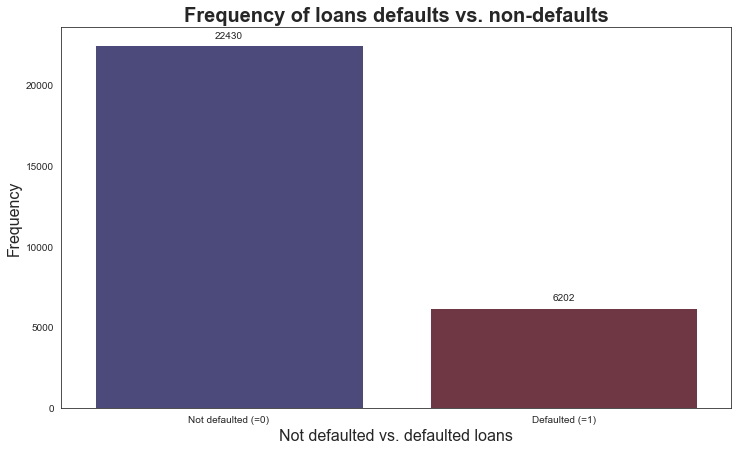

In [57]:
# Distribution of "loan_status" -> dependent variable
plot_args = {
    "df": df_ls,
    "x": "index",
    "y": "loan_status", 
    "plot_options": {
        "kind": "bar",
        "title": "Frequency of loans defaults vs. non-defaults",
        "x_label": "Not defaulted vs. defaulted loans",
        "y_label": "Frequency",
        "palette": "icefire"
    }
}

# Get the distribution
sns_plot(plot_args)

Comment: unbalanced class of defaulted vs. non-defaulted counterparties in the dataset. However, this is not a classification, but a regression task. Hence, overbalancing (SMOTE) is not required in this situation, as it is normal to assume that the class of non-defaulted clients is the one that is represented the most in this context.

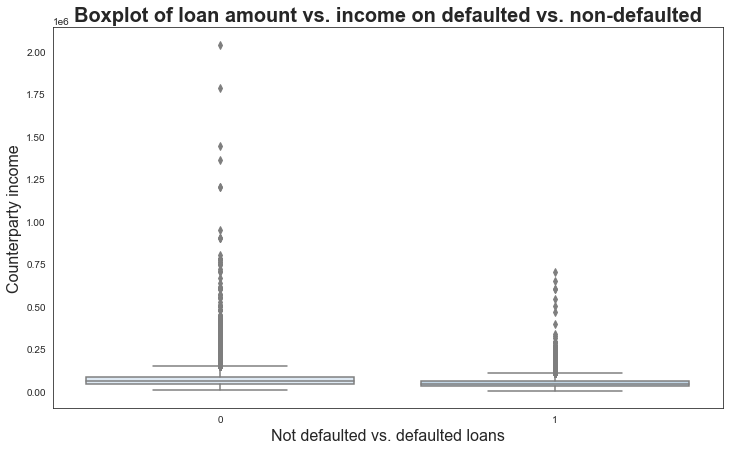

In [63]:
# How is the distribution of income across these categories of loans?
# Loan-status vs. cp_income
plot_args = {
    "df": df_analysis,
    "x": "loan_status",
    "y": "cp_income", 
    "plot_options": {
        "kind": "boxplot",
        "title": "Boxplot of loan amount vs. income on defaulted vs. non-defaulted",
        "x_label": "Not defaulted vs. defaulted loans",
        "y_label": "Counterparty income",
        "palette": "icefire"
    }
}

# Get the distribution
sns_plot(plot_args)

It can be noticed that most of the counterparties in both groups seem to have low income. This fact might be given by the strong presence of young people representing counterparties, who might have lower salaries/income with respect to older people, and thus more inclined to default on such loans. Let's have a closer look at this hypothesis

In [74]:
# Loan-status vs. interest rate
plot_args = {
    "df": df_analysis,
    "x": "cp_income",
    "y": "cp_age", 
    "plot_options": {
        "kind": "scatter",
        "title": "",
        "x_label": "",
        "y_label": "",
        "palette": "",
        "type": "mult"
    }
}

# Get the distribution
sns_plot(plot_args)

AttributeError: 'str' object has no attribute 'x'

In [ ]:
# Loan-status vs. interest rate
plot_args = {
    "df": df_analysis,
    "x": "index",
    "y": "loan_status", 
    "plot_options": {
        "kind": "violin",
        "title": "Frequency of loans defaults vs. non-defaults",
        "x_label": "Not defaulted vs. defaulted loans",
        "y_label": "Frequency",
        "palette": "icefire"
    }
}

# Get the distribution
sns_plot(plot_args)